In [1]:
## Importing all libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [3]:
datadir = '/content/drive/MyDrive/PROJECTS/SelfDrivingCarProject /data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,D:\simulator-windows-64\data\IMG\center_2023_02_28_21_36_17_519.jpg,D:\simulator-windows-64\data\IMG\left_2023_02_28_21_36_17_519.jpg,D:\simulator-windows-64\data\IMG\right_2023_02_28_21_36_17_519.jpg,0.0,0.0,0.0,0.000078
1,D:\simulator-windows-64\data\IMG\center_2023_02_28_21_36_17_627.jpg,D:\simulator-windows-64\data\IMG\left_2023_02_28_21_36_17_627.jpg,D:\simulator-windows-64\data\IMG\right_2023_02_28_21_36_17_627.jpg,0.0,0.0,0.0,0.000078
2,D:\simulator-windows-64\data\IMG\center_2023_02_28_21_36_17_728.jpg,D:\simulator-windows-64\data\IMG\left_2023_02_28_21_36_17_728.jpg,D:\simulator-windows-64\data\IMG\right_2023_02_28_21_36_17_728.jpg,0.0,0.0,0.0,0.000078
3,D:\simulator-windows-64\data\IMG\center_2023_02_28_21_36_17_830.jpg,D:\simulator-windows-64\data\IMG\left_2023_02_28_21_36_17_830.jpg,D:\simulator-windows-64\data\IMG\right_2023_02_28_21_36_17_830.jpg,0.0,0.0,0.0,0.000078
4,D:\simulator-windows-64\data\IMG\center_2023_02_28_21_36_17_932.jpg,D:\simulator-windows-64\data\IMG\left_2023_02_28_21_36_17_932.jpg,D:\simulator-windows-64\data\IMG\right_2023_02_28_21_36_17_932.jpg,0.0,0.0,0.0,0.000078


In [5]:
def imgname(path):
  return ntpath.basename(path)
data['center'] = data['center'].apply(imgname)
data['left'] = data['left'].apply(imgname)
data['right'] = data['right'].apply(imgname)

In [6]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2023_02_28_21_36_17_519.jpg,left_2023_02_28_21_36_17_519.jpg,right_2023_02_28_21_36_17_519.jpg,0.0,0.0,0.0,0.000078
1,center_2023_02_28_21_36_17_627.jpg,left_2023_02_28_21_36_17_627.jpg,right_2023_02_28_21_36_17_627.jpg,0.0,0.0,0.0,0.000078
2,center_2023_02_28_21_36_17_728.jpg,left_2023_02_28_21_36_17_728.jpg,right_2023_02_28_21_36_17_728.jpg,0.0,0.0,0.0,0.000078
3,center_2023_02_28_21_36_17_830.jpg,left_2023_02_28_21_36_17_830.jpg,right_2023_02_28_21_36_17_830.jpg,0.0,0.0,0.0,0.000078
4,center_2023_02_28_21_36_17_932.jpg,left_2023_02_28_21_36_17_932.jpg,right_2023_02_28_21_36_17_932.jpg,0.0,0.0,0.0,0.000078


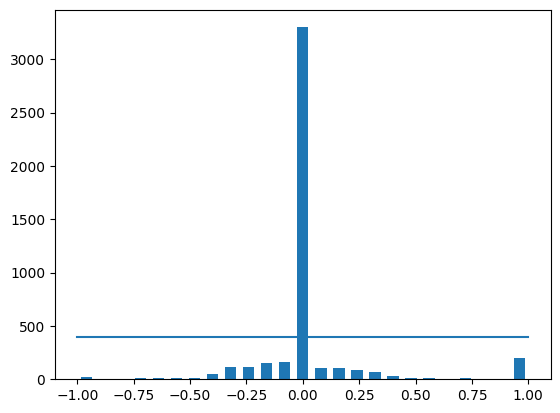

In [7]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [8]:
# Removing the values above the line

remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print("remaining:",len(data))

removed: 2900
remaining: 1707


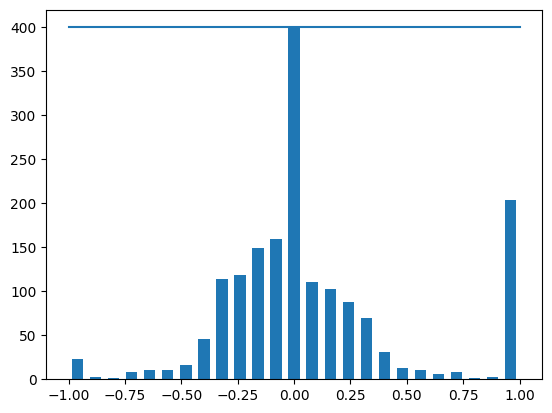

In [9]:
hist,_ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [10]:
def load_img_steering(datadir,df):
  img_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    img_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    img_path.append(os.path.join(datadir, left.strip()))
    steering.append(float(indexed_data[3]) + 0.15)
    # right image append
    img_path.append(os.path.join(datadir, right.strip()))
    steering.append(float(indexed_data[3]) - 0.15)
  img_paths = np.asarray(img_path)
  steerings = np.asarray(steering)
  return img_paths,steering

In [11]:
img_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(img_paths, steerings, test_size = 0.2, random_state = 6)
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))

Training Samples: 4096
Valid Samples: 1025


In [13]:
## Image Augmentation Techniques

## 1. Zooming
def zoom(img):
  zoom = iaa.Affine(scale = (1,1.3))
  image = zoom.augment_image(img)
  return img

## 2. Panning
def pan(img):
  pan = iaa.Affine(translate_percent= {'x' : (-0.1,0.1), 'y' : (-0.1,0.1)})
  img = pan.augment_image(img)
  return img

## 3. Random Brightness
def img_random_brightness(img):
  brightness = iaa.Multiply((0.2, 1.2))
  img = brightness.augment_image(img)
  return img

## 4. Random Flip
def img_random_flip(img, steering):
  img = cv2.flip(img,1)
  steering = -steering
  return img,steering

In [14]:
def random_augment(img, steering):
  img = mpimg.imread(img)
  if np.random.rand() < 0.5:
    img = pan(img)
  if np.random.rand() < 0.5:
    img = zoom(img)
  if np.random.rand() < 0.5:
    img = img_random_brightness(img)
  if np.random.rand() < 0.5:
    img,steering = img_random_flip(img, steering)
  return img, steering

In [ ]:
def img_preprocess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [16]:
def batch_generator(img_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    for i in range(batch_size):
      random_index = random.randint(0, len(img_paths) - 1)
      if istraining:
        im, steering = random_augment(img_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(img_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield(np.asarray(batch_img), np.asarray(batch_steering))

In [17]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides = (2, 2), input_shape = (66, 200, 3), activation = 'elu'))
  model.add(Conv2D(36, (5, 5), strides = (2, 2), activation = 'elu'))
  model.add(Conv2D(48, (5, 5), strides = (2, 2), activation = 'elu'))
  model.add(Conv2D(64, (5, 5), activation = 'elu'))
# model.add(Conv2D(64, (3, 3), activation = 'elu'))
# model.add(Dropout(0.5))


  model.add(Flatten())


  model.add(Dense(100, activation = 'elu'))
# model.add(Dropout(0.5))

  model.add(Dense(100, activation = 'elu'))
# model.add(Dropout(0.5))

  model.add(Dense(100, activation = 'elu'))
# model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
  model.compile(loss = 'mse', optimizer = optimizer)
  return model

model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 18, 64)         76864     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               115300    
                                                                 
 dense_1 (Dense)             (None, 100)               1

history = model.fit_generator(batch_generator(X_train, y_train,100,1),
                              steps_per_epoch = 300,
                              epochs = 100,
                              validation_data = batch_generator(X_valid, y_valid, 100, 0),
                              validation_steps = 200,
                              verbose = 1,
                              shuffle = 1)